# Analyzer of Stocks


## Libraries


In [1]:
# Import necessary libraries
from dotenv import load_dotenv
from libs import indicators, signals
import alpaca_trade_api as trade_api
import os
import pandas as pd
import matplotlib.pyplot as plt


## Alpaca Connection


In [2]:
load_dotenv()


True

In [3]:
# Get keys and URL for Alpaca API
alpaca_key = os.getenv('APCA_API_KEY_ID')
alpaca_secret_key = os.getenv('APCA_API_SECRET_KEY')
alpaca_paper_trade_url = os.getenv('APCA_API_PAPER_URL')


In [4]:
# Instantiate Alpaca connection
alpaca = trade_api.REST(alpaca_key, alpaca_secret_key, base_url=alpaca_paper_trade_url)


In [5]:
# Default parameters
ticker = 'TWOU'

today = pd.Timestamp('today')
today_date = f'{today:%Y-%m-%d}'

start_date = pd.Timestamp('2018-01-01', tz='America/New_York').isoformat()

end_date = pd.Timestamp(today_date, tz='America/New_York').isoformat()

timeframe = '1D'


In [6]:
# Get dataframe of ticker data
df_ohlcv_original = alpaca.get_barset(ticker, timeframe, start=start_date, end=end_date).df

# Copy of original dataframe
df_ohlcv = df_ohlcv_original[ticker].copy()


## Bollinger Bands


In [7]:
# Generate Bollinger Band data
df_updated = indicators.bollinger_band_generator(df_ohlcv)


## Keltner Channels


In [8]:
# Generate average true range values
df_updated = indicators.keltner_channel_generator(df_updated)


## Bollinger Bands and Keltner Channels Indicators Plot


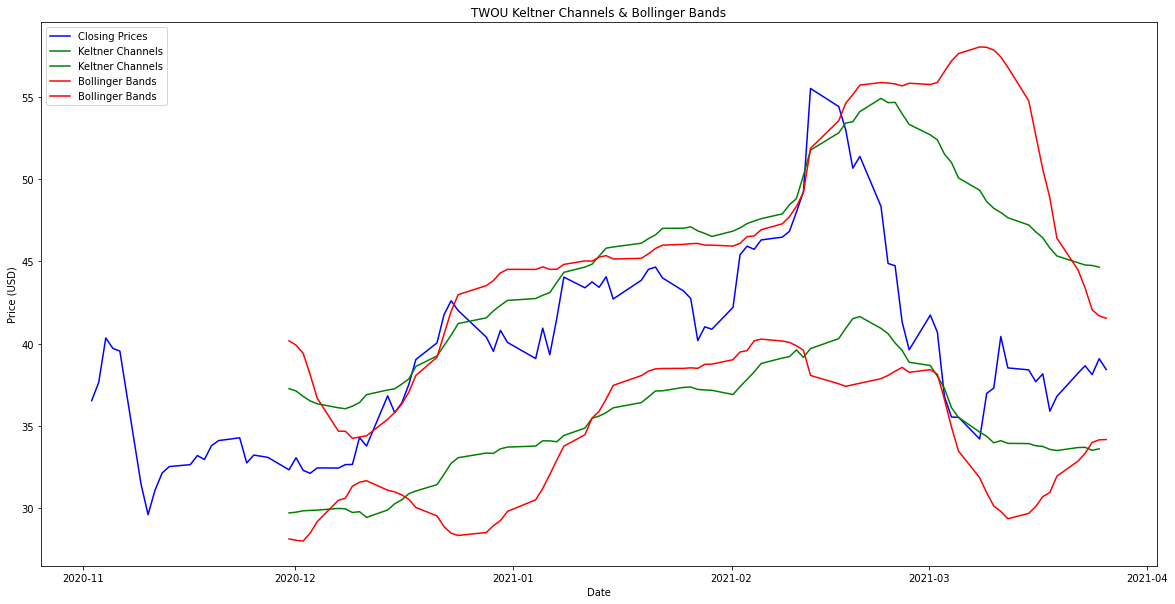

In [9]:
# Generate Keltner Channels and Bollinger Bands plot
plt.figure(figsize=(20,10))
plt.title(f'{ticker} Keltner Channels & Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.plot(df_updated[['close']], color='b', label='Closing Prices')
plt.plot(df_updated[['kc_upper', 'kc_lower']], color="g", label='Keltner Channels')
plt.plot(df_updated[['bb_upper', 'bb_lower']], color="r", label='Bollinger Bands')
plt.legend(loc='upper left')


## MACD 


In [10]:
df_updated = indicators.macd_generator(df_updated, 5, 35)
df_updated = signals.macd(df_updated, 5)


<AxesSubplot:title={'center':'MACD Fast and Slow'}, xlabel='Date', ylabel='Price (USD)'>

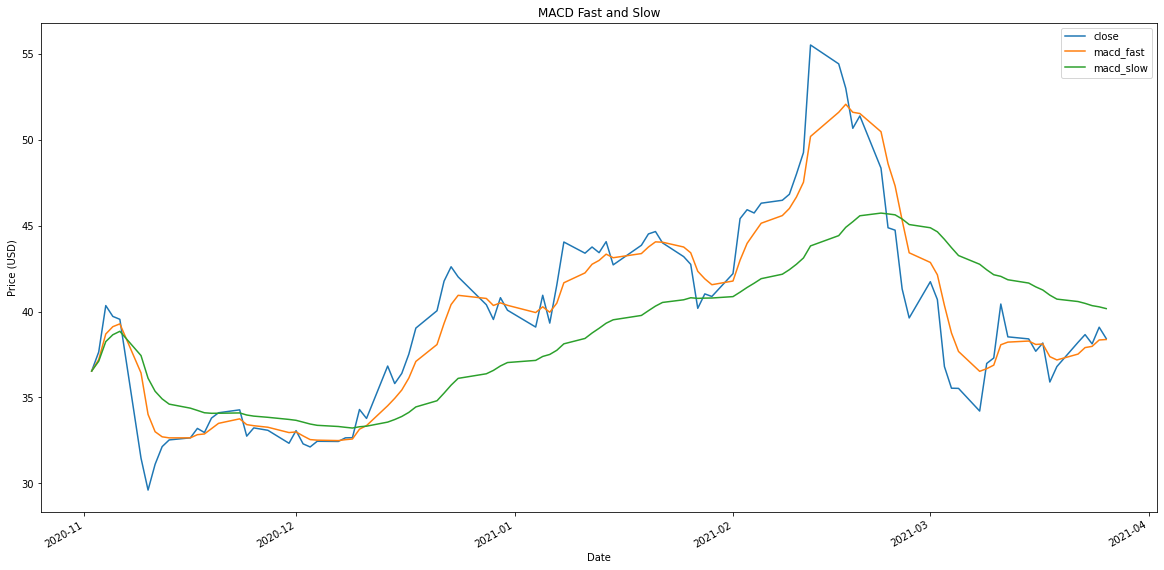

In [11]:
# Generate MACD Fast and Slow plot
df_updated[['close', 'macd_fast', 'macd_slow']].plot(figsize=(20,10), title='MACD Fast and Slow', xlabel='Date', ylabel='Price (USD)')


<AxesSubplot:title={'center':'MACD Signal With Divergence'}, xlabel='Date', ylabel='Amount of Divergence'>

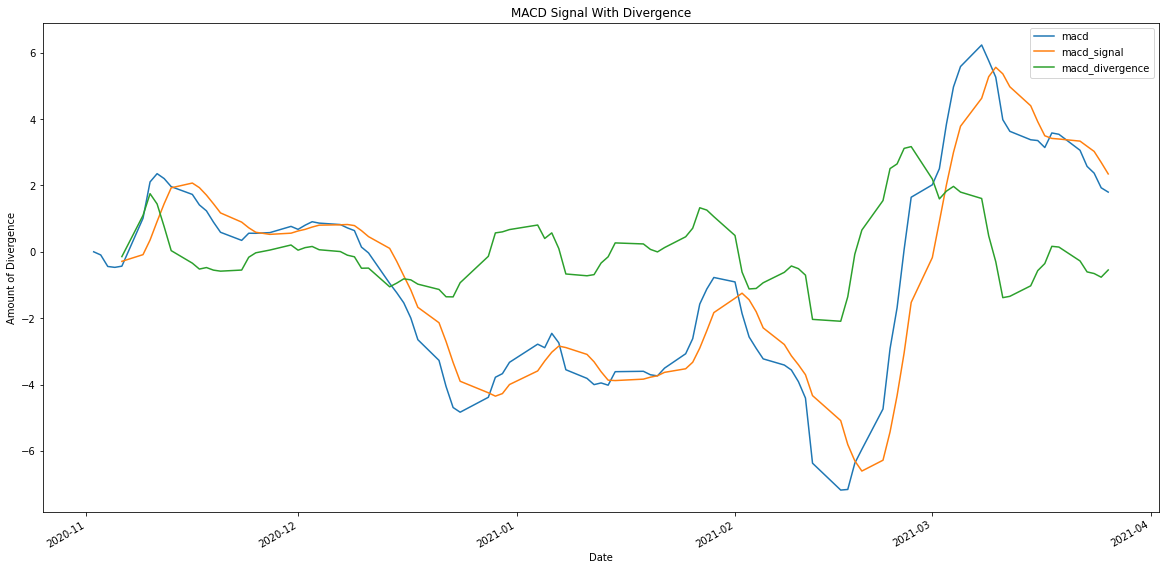

In [12]:
# Generate MACD with signal and divergence lines
df_updated[['macd', 'macd_signal', 'macd_divergence']].plot(figsize=(20,10), title='MACD Signal With Divergence', xlabel='Date', ylabel='Amount of Divergence')


In [13]:
df_updated = signals.bbands_inside_kchannels(df_updated)
df_updated.tail()


c:\Users\jonat\Documents\personal\bookish-fiesta\libs\signals.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_name['squeeze'][selection] = 1
C:\Users\jonat\anaconda3\envs\bookish_fiesta_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,open,high,low,close,volume,bb_upper,bb_middle,bb_lower,atr,kc_upper,kc_middle,kc_lower,macd_fast,macd_slow,macd,macd_signal,macd_divergence,squeeze
time,,,,,,,,,,,,,,,,,,
2021-03-22 00:00:00-04:00,36.82,38.78,36.80,38.21,1247563,44.488656,38.6760,32.863344,2.808714,44.923199,39.305771,33.688342,37.526145,40.585457,3.059312,3.335456,-0.276144,0.0
2021-03-23 00:00:00-04:00,38.72,39.30,37.91,38.66,1283419,43.392593,38.3650,33.337407,2.771692,44.787648,39.244265,33.700882,37.904097,40.478067,2.573970,3.179732,-0.605762,0.0
2021-03-24 00:00:00-04:00,39.08,39.87,37.45,38.12,1934743,42.067869,38.0340,34.000131,2.809628,44.756442,39.137186,33.517930,37.976065,40.346578,2.370514,3.025373,-0.654860,1.0
2021-03-25 00:00:00-04:00,37.45,39.25,36.08,39.09,1596709,41.688307,37.9225,34.156693,2.761089,44.654871,39.132692,33.610513,38.347376,40.276524,1.929148,2.694906,-0.765758,1.0
2021-03-26 00:00:00-04:00,38.98,39.46,37.16,38.43,1018343,41.551208,37.8625,34.173792,NaN,NaN,39.065766,NaN,38.374918,40.173600,1.798683,2.346325,-0.547642,0.0
